This notebook should be run on Google Colab.
<a href="https://colab.research.google.com/github/SavvinaDaniil/UnfairnessOfPopularityBias/blob/main/4. Music_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

# Process
In this notebook, I will train the music recommendation algorithms using two different packages: <a href="http://surpriselib.com/">Surprise</a> & <a href="https://cornac.readthedocs.io/en/latest/">Cornac</a>. 

## A. Import lbraries

In [3]:
!pip uninstall tensorflow -y
!pip install tensorflow-gpu==1.15
!apt install --allow-change-held-packages libcudnn7=7.4.1.5-1+cuda10.0

Found existing installation: tensorflow 2.9.2
Uninstalling tensorflow-2.9.2:
  Successfully uninstalled tensorflow-2.9.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 411.5 MB 7.7 kB/s 
     |████████████████████████████████| 50 kB 7.1 MB/s 
     |████████████████████████████████| 3.8 MB 53.6 MB/s 
     |████████████████████████████████| 503 kB 70.0 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=3564c853a4a899fe4992abfcb738721ca572f22112b4a06a7decf5232042135c
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installati

In [4]:
!pip install cornac

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.4 MB 6.1 MB/s 


In [5]:
# !pip install surprise

In [7]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import random as rd
import pandas as pd
import numpy as np
from tqdm import tqdm
import time

# Cornac imports
import cornac
from cornac.eval_methods import RatioSplit
from cornac.data import Reader as CornacReader #Reader exists in both packages
from cornac.models import MostPop, MF, PMF, BPR, NeuMF, WMF, HPF, VAECF, ItemKNN, UserKNN, BaselineOnly 
from cornac.models import NMF as CornacNMF #NMF exists in both packages
from cornac.metrics import MAE, MSE, RMSE, Precision, Recall, NDCG, AUC, MAP, FMeasure, MRR

# # Surprise imports
# from surprise import BaselineOnly, KNNBasic, KNNWithMeans, SVDpp, SVD
# from surprise import NMF as SurpriseNMF
# from surprise import Dataset
# from surprise import Reader as SurpriseReader
# from surprise.model_selection import train_test_split
# from surprise import accuracy


from collections import defaultdict
from scipy import stats
from numpy.linalg import norm
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
# set plot style: grey grid in the background:
sns.set(style="darkgrid")
pd.set_option("display.precision", 8)

## B. Set hyperparameters
There are certain hyperparameters that need to be tuned before the run. 

In [8]:
# constants and initialization
rating_threshold = 1.0 # needed for the cornac library: Threshold used to binarize rating values into positive or negative feedback for model evaluation using ranking metrics (rating metrics are not affected). 
my_seed = 0
test_size = 0.2 # the percentage of "hold out" data that are used for testing
predict_col = "rating"
user_col = "user"
top_fraction = 0.2 # the amount of items that will be considered "popular"

rd.seed(my_seed) #seed for random functions
np.random.seed(my_seed) #seed for all numpy stuff

## C. Read files

### Make data choice
The reader has to manually choose whether to run the entire data set or the subset using the alt_dataset variable.

In [9]:
alt_dataset = True

In [10]:
item_col = "artist"
if alt_dataset == False:
  user_events_file = 'https://media.githubusercontent.com/media/SavvinaDaniil/UnfairnessOfPopularityBias/main/data/ratings_music.txt'
  cols = ['user',item_col, 'album', 'track', 'timestamp']
  df_events = pd.read_csv(user_events_file, sep = '\t', names = cols)
  print('No. of user events: ' + str(len(df_events)))
  # create user-item matrix
  df_events = df_events.groupby(['user', item_col]).size().reset_index(name='rating')
else:
  user_events_file = 'https://raw.githubusercontent.com/SavvinaDaniil/UnfairnessOfPopularityBias/main/data/relevant_music_data_20.csv'
  df_events = pd.read_csv(user_events_file, index_col=0)


print('No. user-item interactions: ' + str(len(df_events)))
df_events = df_events.astype("int")

No. user-item interactions: 1008479


## D. Data analysis

In [11]:
def users_and_items(df_events, user_col, item_col):
    print('No. user events: ' + str(len(df_events)))
    print('No. items: ' + str(len(df_events[item_col].unique())))
    print('No. users: ' + str(len(df_events[user_col].unique())))
    print("\n")
def user_distribution(df_events, user_col, item_col):
    user_dist = df_events[user_col].value_counts() 
    num_users = len(user_dist)
    print('Mean '+item_col+'s per user: ' + str(np.round(user_dist.mean(),1))) 
    print('Min '+item_col+'s per user: ' + str(np.round(user_dist.min(),1))) 
    print('Max '+item_col+'s per user: ' + str(np.round(user_dist.max(),1)))
    print("\n")
    return user_dist, num_users
def item_distribution(df_events, user_col, item_col):
    item_dist = df_events[item_col].value_counts()
    num_items = len(item_dist)
    print('Mean users per '+item_col+': ' + str(np.round(item_dist.mean(),1))) 
    print('Min users per '+item_col+': ' + str(np.round(item_dist.min(),1))) 
    print('Max users per '+item_col+': ' + str(np.round(item_dist.max(),1))) 
    print("\n")
    return item_dist, num_items

In [12]:
users_and_items(df_events, user_col, item_col)
user_dist, num_users = user_distribution(df_events, user_col, item_col)
item_dist, num_items = item_distribution(df_events, user_col, item_col)

No. user events: 1008479
No. items: 12690
No. users: 3000


Mean artists per user: 336.2
Min artists per user: 4
Max artists per user: 2057


Mean users per artist: 79.5
Min users per artist: 21
Max users per artist: 1389




In [13]:
# create item dataframe with normalized item counts
df_item_dist = pd.DataFrame(item_dist) # turn the series into a dataframe
df_item_dist.columns = ['count']
df_item_dist['count'] /= num_users # basically the popularity of every item


In [14]:
df_item_dist.head()

,count
135,0.46300000
1602,0.45300000
46,0.44166667
320,0.43233333
27,0.43000000


In [15]:
def plot_data_distribution(item_dist, item_col, dividing = [False, 0], log = False):
    plt.figure()
    ax = plt.axes()
    ax.spines['bottom'].set_color('w')
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('w')
    ax.spines['left'].set_zorder(0)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    ax.set_facecolor("aliceblue")
    plt.grid(color = "w",linewidth = 2 )
    if dividing[0]:
        x0 = int(len(item_dist.values)*dividing[1])
        y = range(len(item_dist))
        plt.plot(y[:x0+1], item_dist.values[:x0+1], label = "Popular "+item_col+"s", linewidth = 5)
        plt.plot(y[x0:], item_dist.values[x0:], label = "Non Popular "+item_col+"s", linewidth = 5)
    else:
        plt.plot(item_dist.values)
    plt.xticks(fontsize='13')
    plt.yticks(fontsize='13')
    add = ""
    if log:
        plt.xscale('log')
        plt.yscale('log')
        add = " (log)"
    plt.xlabel(item_col+add, fontsize='14')
    plt.ylabel('Number of users' + add, fontsize='15')
    plt.show(block=True)
def plot_popularity_distribution(pop_fraq, item_col, dividing = [False,0]):
    plt.figure()
    ax = plt.axes()
    ax.spines['bottom'].set_color('w')
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('w')
    ax.spines['left'].set_zorder(0)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    
    ax.set_facecolor("aliceblue")
    plt.grid(color = "w",linewidth = 2 )
    if dividing[0]:
        y = range(len(pop_fraq))
        x0 = int(len(y)*dividing[1]) 
        x1 = int(len(y)*(1-dividing[1]))
        x= sorted(pop_fraq)
        plt.plot(y[:x0+1],x[:x0+1], label="LowMS users", linewidth = 5)
        plt.plot(y[x0:x1+1],x[x0:x1+1], label = "MedMS users", linewidth = 5)
        plt.plot(y[x1:],x[x1:], label = "HighMS users", linewidth =5)
    else:
        plt.plot(sorted(pop_fraq))
    plt.xlabel('User', fontsize='15')
    plt.xticks(fontsize='13')
    plt.ylabel('Ratio of popular '+item_col+'s', fontsize='15')
    plt.yticks(fontsize='13')
    plt.axhline(y=0.8, color='black', linestyle='--', label='80% ratio of popular '+item_col+'s')
    plt.legend(fontsize='15')
    plt.show(block=True)

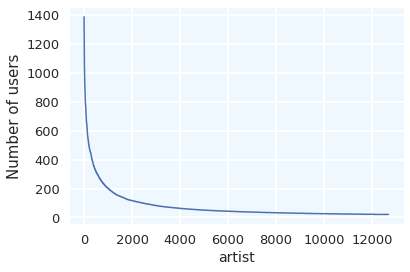

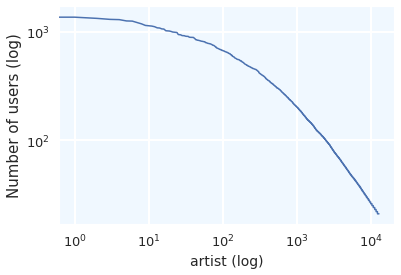

In [16]:
plot_data_distribution(item_dist, item_col)
plot_data_distribution(item_dist, item_col, [False, 0],True)

## E. Popularity in the data

In [17]:
num_top = int(top_fraction * num_items)
top_item_dist = item_dist[:num_top]
print('No. top items: ' + str(len(top_item_dist)))

No. top items: 2538


In [18]:
def read(low_user_file, medium_user_file, high_user_file):
    low_users = pd.read_csv(low_user_file, sep=',').set_index('user_id')
    medium_users = pd.read_csv(medium_user_file, sep=',').set_index('user_id')
    high_users = pd.read_csv(high_user_file, sep=',').set_index('user_id')
    no_users = len(low_users) + len(medium_users) + len(high_users)
    print('No. of users: ' + str(no_users))
    
    mainstreaminess = "M_global_R_APC"
    
    print('Average mainstreaminess per user for low: ' + str(low_users[mainstreaminess].mean()))
    print('Average mainstreaminess per user for med: ' + str(medium_users[mainstreaminess].mean()))
    print('Average mainstreaminess per user for high: ' + str(high_users[mainstreaminess].mean()))
    return no_users, low_users, medium_users, high_users

In [19]:
def calculate_popularity_for_music(df_events, top_item_dist, item_dist, num_users, user_col, item_col, low_users, medium_users, high_users):
    pop_count = [] # number of top items per user
    user_hist = [] # user history sizes
    pop_fraq = [] # relative number of top items per user
    pop_item_fraq = [] # average popularity of items in user profiles
    low_profile_size = 0
    low_gap = 0
    medium_profile_size = 0
    medium_gap = 0
    high_profile_size = 0
    high_gap = 0
    low_ratio = 0
    medium_ratio = 0
    high_ratio = 0
    
    i=0
    for u, df in df_events.groupby(user_col):
        no_user_items = len(set(df[item_col]))
        no_user_pop_items = len(set(df[item_col]) & set(top_item_dist.index))
        pop_count.append(no_user_pop_items)
        user_hist.append(no_user_items) 
        pop_fraq.append(no_user_pop_items / no_user_items)
        user_pop_item_fraq = sum(item_dist[df[item_col]] / num_users) / no_user_items
        pop_item_fraq.append(user_pop_item_fraq)
    
        if u in low_users.index: # get user group-specific values
            low_profile_size += no_user_items
            low_gap += user_pop_item_fraq
            low_ratio += no_user_pop_items / no_user_items
        elif u in medium_users.index:
            medium_profile_size += no_user_items
            medium_gap += user_pop_item_fraq
            medium_ratio += no_user_pop_items / no_user_items
        else:
            high_profile_size += no_user_items
            high_gap += user_pop_item_fraq
            high_ratio += no_user_pop_items / no_user_items
        i+=1
        if i%1000==0:
            print(i)
    low_profile_size /= len(low_users)
    medium_profile_size /= len(medium_users)
    high_profile_size /= len(high_users)
    low_ratio /= len(low_users)
    medium_ratio /= len(medium_users)
    high_ratio /= len(high_users)
    low_gap /= len(low_users)
    medium_gap /= len(medium_users)
    high_gap /= len(high_users)
  
    return pop_count,user_hist,pop_fraq, pop_item_fraq, low_profile_size, medium_profile_size, high_profile_size, low_gap, medium_gap, high_gap, low_ratio, medium_ratio, high_ratio
def calculate_popularity(df_events, top_item_dist, item_dist, num_users, user_col, item_col):
    pop_count = [] # number of top items per user
    user_hist = [] # user history sizes
    pop_fraq = [] # relative number of top items per user
    pop_item_fraq = [] # average popularity of items in user profiles
    i=0
    for u, df in df_events.groupby(user_col):
        no_user_items = len(set(df[item_col]))
        no_user_pop_items = len(set(df[item_col]) & set(top_item_dist.index))
        pop_count.append(no_user_pop_items)
        user_hist.append(no_user_items) 
        pop_fraq.append(no_user_pop_items / no_user_items)
        user_pop_item_fraq = sum(item_dist[df[item_col]] / num_users) / no_user_items
        pop_item_fraq.append(user_pop_item_fraq)
        i+=1
        if i%1000==0:
            print(i)
    return pop_count,user_hist,pop_fraq, pop_item_fraq

In [20]:
def sort_user_dist(user_dist,pop_count, user_hist,pop_fraq,pop_item_fraq, by = "pop_fraq"):
    user_dist = user_dist.sort_index()
    user_dist_sorted = pd.DataFrame(data = user_dist)
    
    user_dist_sorted.columns = ["count"]
    
    user_dist_sorted["pop_count"] = pop_count
    user_dist_sorted["user_hist"] = user_hist
    user_dist_sorted["pop_fraq"] = pop_fraq
    user_dist_sorted["pop_item_fraq"] = pop_item_fraq
    
    user_dist_sorted = user_dist_sorted.sort_values(by=[by])
    return user_dist_sorted

def split(user_dist_sorted, top_fraction):
    low, med, high = np.split(user_dist_sorted, [int(top_fraction*len(user_dist_sorted)), int((1-top_fraction)*len(user_dist_sorted))])
    return low, med, high
def calculate_group_characteristics(low, med, high):
    low_profile_size = low.user_hist.mean()
    med_profile_size = med.user_hist.mean()
    high_profile_size = high.user_hist.mean()
    
    low_nr_users = len(low)
    med_nr_users = len(med)
    high_nr_users = len(high)
    
    low_GAP = low.pop_item_fraq.mean()
    med_GAP = med.pop_item_fraq.mean()
    high_GAP = high.pop_item_fraq.mean()
    
    return low_profile_size, med_profile_size, high_profile_size, low_nr_users, med_nr_users, high_nr_users, low_GAP, med_GAP, high_GAP

### Make notion of popularity propensity choice
The reader has to manually choose how to divide the users into groups according to their propensity for popular items.

In [21]:
popularity_function = {'pop_one': "pop_fraq",
             'pop_two': "pop_item_fraq" ,
             'pop_three': "mainstreaminess" }

In [81]:
pop_notion = "pop_one"

In [82]:
if pop_notion == "pop_three":
  low_user_file = "https://media.githubusercontent.com/media/SavvinaDaniil/UnfairnessOfPopularityBias/main/data/low_main_users.txt"
  medium_user_file = "https://media.githubusercontent.com/media/SavvinaDaniil/UnfairnessOfPopularityBias/main/data/medium_main_users.txt"
  high_user_file = "https://media.githubusercontent.com/media/SavvinaDaniil/UnfairnessOfPopularityBias/main/data/high_main_users.txt"
  no_users, low, med, high= read(low_user_file, medium_user_file, high_user_file)
  pop_count,user_hist,pop_fraq, pop_item_fraq, low_profile_size, med_profile_size, high_profile_size, low_GAP, med_GAP, high_GAP, low_ratio, med_ratio, high_ratio = calculate_popularity_for_music(df_events, top_item_dist, item_dist, num_users, user_col, item_col, low, med, high)
  low_nr_users = 1000
  med_nr_users = 1000
  high_nr_users = 1000
else:
  pop_count,user_hist,pop_fraq, pop_item_fraq = calculate_popularity(df_events, top_item_dist, item_dist, num_users, user_col, item_col)
  user_dist_sorted = sort_user_dist(user_dist,pop_count, user_hist,pop_fraq,pop_item_fraq, by = popularity_function[pop_notion])
  low, med, high = split(user_dist_sorted, top_fraction)
  low_profile_size, med_profile_size, high_profile_size, low_nr_users, med_nr_users, high_nr_users, low_GAP, med_GAP, high_GAP = calculate_group_characteristics(low, med, high)


1000
2000
3000


In [83]:
print('LowMS GAP: ' + str(low_GAP))
print('MedMS GAP: ' + str(med_GAP))
print('HighMS GAP: ' + str(high_GAP))

LowMS GAP: 0.05164793247914172
MedMS GAP: 0.08470085441420941
HighMS GAP: 0.12115518571314757


In [74]:
def plot_popularity_distribution(pop_fraq, item_col, dividing = [False,0]):
    plt.figure()
    ax = plt.axes()
    ax.spines['bottom'].set_color('w')
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('w')
    ax.spines['left'].set_zorder(0)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    
    ax.set_facecolor("aliceblue")
    plt.grid(color = "w",linewidth = 2 )
    if dividing[0]:
        y = range(len(pop_fraq))
        x0 = int(len(y)*dividing[1]) 
        x1 = int(len(y)*(1-dividing[1]))
        x= sorted(pop_fraq)
        plt.plot(y[:x0+1],x[:x0+1], label="LowMS users", linewidth = 5)
        plt.plot(y[x0:x1+1],x[x0:x1+1], label = "MedMS users", linewidth = 5)
        plt.plot(y[x1:],x[x1:], label = "HighMS users", linewidth =5)
    else:
        plt.plot(sorted(pop_fraq))
    plt.xlabel('User', fontsize='15')
    plt.xticks(fontsize='13')
    plt.ylabel('Ratio of popular '+item_col+'s', fontsize='15')
    plt.yticks(fontsize='13')
    plt.axhline(y=0.8, color='black', linestyle='--', label='80% ratio of popular '+item_col+'s')
    plt.legend(fontsize='15')
    plt.show(block=True)

def plot_profile_size_vs_popularity(pop_metric, user_hist, way, item_col):
    plt.figure()
    ax = plt.axes()
    ax.spines['bottom'].set_color('w')
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('w')
    ax.spines['left'].set_zorder(0)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    
    ax.set_facecolor("aliceblue")
    plt.grid(color = "w",linewidth = 2 )
    slope, intercept, r_value, p_value, std_err = stats.linregress(user_hist, pop_metric)
    print('R-value: ' + str(r_value))
    line = slope * np.array(user_hist) + intercept
    plt.plot(user_hist, pop_metric, 'o', user_hist, line)
    plt.xlabel('User profile size', fontsize='15')
    plt.xticks(fontsize='13')
    if way == "count":
        ylabel = "Number of popular "+item_col+"s"
    elif way == "percentage":
        ylabel = 'Percentage of popular '+item_col+'s'
    else:
        ylabel = "Average popularity of "+item_col+"s"
    plt.ylabel(ylabel, fontsize='15')
    plt.yticks(fontsize='13')
    plt.show(block=True)

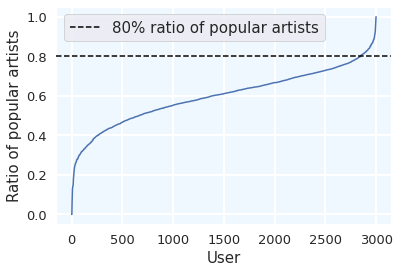

R-value: 0.9617464474616385


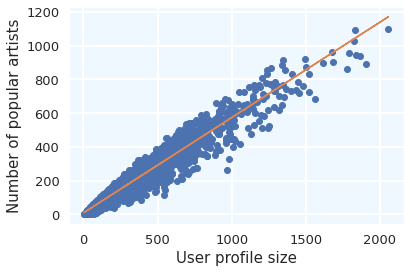

R-value: -0.056057853315537816


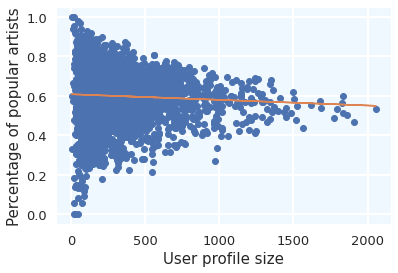

R-value: -0.2244508506298754


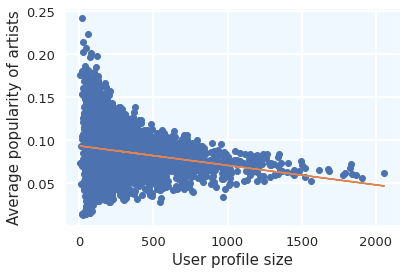

In [75]:
plot_popularity_distribution(pop_fraq, item_col)
plot_profile_size_vs_popularity(pop_count,user_hist, "count", item_col)
plot_profile_size_vs_popularity(pop_fraq,user_hist, "percentage", item_col)
plot_profile_size_vs_popularity(pop_item_fraq,user_hist, "average", item_col)

## F. User groups

In [27]:
def plot_group_characteristics(low_nr, med_nr, high_nr, way, item_col):
    plt.figure()
    ax = plt.axes()
    ax.spines['bottom'].set_color('w')
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('w')
    ax.spines['left'].set_zorder(0)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    
    ax.set_facecolor("aliceblue")
    plt.bar(np.arange(3), [low_nr, med_nr, high_nr])
    plt.xticks(np.arange(3), ['LowMS', 'MedMS', 'HighMS'])
    plt.xlabel('User group')
    if way=="size":
        ylabel = 'Average user profile size'
    else:
        ylabel = "Number of users per group"
    plt.ylabel(ylabel)
    
    print('LowMS: ' + str(low_nr))
    print('MedMS: ' + str(med_nr))
    print('HighMS: ' + str(high_nr))
    plt.show(block=True)

LowMS: 600
MedMS: 1800
HighMS: 600


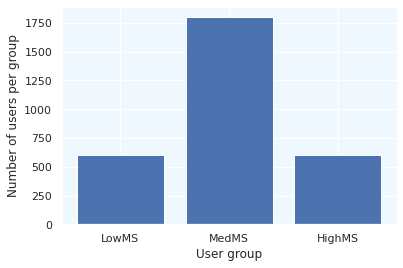

LowMS: 336.8666666666667
MedMS: 385.24833333333333
HighMS: 188.18666666666667


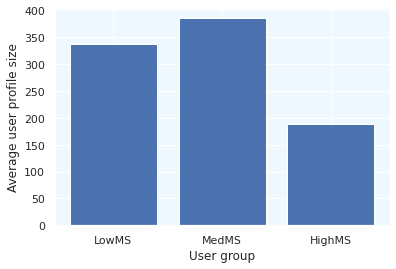

In [28]:
plot_group_characteristics(low_nr = low_nr_users, med_nr = med_nr_users, high_nr = high_nr_users, way = "number", item_col = item_col)
plot_group_characteristics(low_profile_size, med_profile_size, high_profile_size, way = "size", item_col = item_col)

In [29]:
# plot_data_distribution(item_dist, item_col, dividing = [True, top_fraction], log = False)
# plot_popularity_distribution(pop_fraq, item_col, dividing = [True,top_fraction])

In [30]:
scaled_df_events = pd.DataFrame()
for user_id, group in df_events.groupby('user'):  
    scaler = MinMaxScaler(feature_range=(1, 1000)) #"βαθμολογια" 1 με 1000
    scaled_ratings = scaler.fit_transform(group[predict_col].values.reshape(-1, 1).astype(float))
    new_rows = group.copy()
    new_rows[predict_col] = scaled_ratings
    scaled_df_events = scaled_df_events.append(new_rows)

In [31]:
df_events = scaled_df_events

## G. Recommendation

In [32]:
df_events.head()

,user,artist,rating
0,1021445,12,184.22270742
1,1021445,16,1.00000000
2,1021445,28,27.17467249
3,1021445,29,1.00000000
4,1021445,46,1.00000000


### G.1 Cornac
The library used by the book paper. It contains many algorithms.

In [33]:
df_events_cornac = df_events.copy()
mapping_dict = {} # Create a dictionary that maps each artist to an integer.
i=0
for art in df_events_cornac[item_col].unique():
    mapping_dict[art] = i
    i+=1
df_events_cornac[item_col] = df_events_cornac[item_col].map(lambda x: mapping_dict.get(x,x)) # Map in the ratings file

In [34]:
df_events_cornac.user = df_events_cornac.user.astype("string")
df_events_cornac.artist = df_events_cornac.artist.astype("string")

In [35]:
df_item_dist_cornac = df_item_dist.rename(index = mapping_dict)

In [36]:
data = list(df_events_cornac[[user_col,item_col,predict_col]].to_records(index = False))

In [37]:
data[:3]

[('1021445', '0', 184.22270742),
 ('1021445', '1', 1.),
 ('1021445', '2', 27.17467249)]

In [38]:
# Split the data based on ratio
rs = RatioSplit(data=data, test_size=test_size, rating_threshold=rating_threshold, seed=0)

In [39]:
all_items = set(range(rs.total_items)) # needed for later

In [40]:
# Define the two different options for UserKNN, with and without mean centering
usKNN = UserKNN(k=40, similarity = 'cosine', mean_centered=False, seed = my_seed, verbose=True)
usKNN_means = UserKNN(k=40, similarity = 'cosine', mean_centered=True, seed = my_seed, verbose=True)

#### Training

In [41]:
# initialize models, here we are comparing: simple, traditional, and neural networks based models
models = [
          # 1: Random
          # 2: MostPop
          MostPop(),
          # 3: UserKNN
          usKNN,
          # 4: ItemKNN
          ItemKNN(k=40, similarity = 'cosine', mean_centered=False, seed = my_seed, verbose=True),
          # 5: UserKNN with means
          usKNN_means,
          ## 6: BaselineOnly
          #BaselineOnly(verbose=True),
          # 7: BPR
          BPR(k=10, max_iter=200, learning_rate=0.001, lambda_reg=0.01, seed=123, verbose=True),
          # 8: MF
          MF(k=30, max_iter=100, learning_rate=0.01, lambda_reg=0.001, seed=123, verbose=True),
          # 9: PMF
          PMF(k=10, max_iter=100, learning_rate=0.001, lambda_reg=0.001, verbose=True),
          # 10: NMF
          CornacNMF(k=15, max_iter=50, learning_rate=0.005, lambda_u=0.06, lambda_v=0.06, lambda_bu=0.02, lambda_bi=0.02, use_bias=False, verbose=True, seed=123),
          # 11: WMF
          WMF(k=50, max_iter=50, learning_rate=0.001, lambda_u=0.01, lambda_v=0.01, verbose=True, seed=123),
          # 12: PF
          HPF(k=50, seed=123, hierarchical=False, name="PF", verbose=True),
          # 13: NueMF
          NeuMF(num_factors=8, layers=[32, 16, 8], act_fn="tanh", num_epochs=1, num_neg=3, batch_size=256, lr=0.001, seed=42, verbose=True),
          # 14: VAECF
          VAECF(k=10, autoencoder_structure=[20], act_fn="tanh", likelihood="mult", n_epochs=100, batch_size=100, learning_rate=0.001, beta=1.0, seed=123, use_gpu=True, verbose=True)
          ]

In [42]:
algo_names = ["Random",
              "MostPop", 
              "UserKNN",
              "ItemKNN", 
              "UserKNN with means", 
              "BPR",
              "MF",
              "PMF",
              "NMF",
              "WMF",
              "HPF",
              "NeuMF",
              "VAECF"
              ] # in the order that they are in the model list

In [43]:
# define metrics to evaluate the models
metrics = [MAE()]

# put it together in an experiment, voilà!
start = time.time()
exp = cornac.Experiment(eval_method=rs, models=models, metrics=metrics, user_based=True)
exp.run()
end = time.time()
print(round(end-start), "seconds.")

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/12690 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Learning...
epoch 0, loss: 155084.796066
epoch 1, loss: 86975.061783
epoch 2, loss: 53418.749663
epoch 3, loss: 38709.684058
epoch 4, loss: 30908.752813
epoch 5, loss: 26151.894522
epoch 6, loss: 23008.108092
epoch 7, loss: 20840.053146
epoch 8, loss: 19296.269270
epoch 9, loss: 18163.060215
epoch 10, loss: 17307.567131
epoch 11, loss: 16645.596483
epoch 12, loss: 16122.517978
epoch 13, loss: 15701.942342
epoch 14, loss: 15358.960617
epoch 15, loss: 15076.048771
epoch 16, loss: 14840.543998
epoch 17, loss: 14643.062928
epoch 18, loss: 14476.492447
epoch 19, loss: 14335.331996
epoch 20, loss: 14215.253791
epoch 21, loss: 14112.801287
epoch 22, loss: 14025.176958
epoch 23, loss: 13950.090024
epoch 24, loss: 13885.645940
epoch 25, loss: 13830.265046
epoch 26, loss: 13782.621198
epoch 27, loss: 13741.594617
epoch 28, loss: 13706.235288
epoch 29, loss: 13675.734139
epoch 30, loss: 13649.400158
epoch 31, loss: 13626.642038
epoch 32, loss: 13606.953358
epoch 33, loss: 1

  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!
Learning...
Learning completed!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


TEST:
...
        |      MAE | Train (s) | Test (s)
------- + -------- + --------- + --------
MostPop | 193.9530 |    0.0655 |   3.0797
UserKNN |  66.5476 |    1.7670 |  31.7022
ItemKNN |  65.7395 |   13.3425 |  43.4721
UserKNN |  67.1216 |    1.3953 |  30.1755
BPR     |  58.0693 |   56.6156 |   4.1809
MF      |      nan |    6.8763 |   3.7426
PMF     |  72.1270 |   42.9140 |   4.1993
NMF     |  57.4447 |    5.0255 |   4.3694
WMF     |  55.5922 |   88.5483 |   3.8124
PF      |  54.6662 | 1217.1104 |   3.1300
NeuMF   |  58.3551 |   88.3599 | 121.7277
VAECF   |  58.3551 |  228.2380 | 139.0968

2143 seconds.


#### Ranking and recommendation
We have identified three evaluation strategies:
1. For every user in the **train set** rank **all items**. | Book paper, *eva_one*
2. For every user in the **test set** rank **only the items this user has rated in the test set**. | Music paper, *eva_two*
3. For every user in the **test set** rank **only the items this user has NOT rated in the train set**. | Movie(?) paper, *eva_three*

For every evaluation strategy, we define a function that recommends the appropriate items to the appropriate users as described above. 

In [44]:
def get_top_n_eva_one(algo_name,i, n=10):
  model = exp.models[i]
  print(algo_name + " model is selected:")
  top_n = defaultdict(list)
  for uid in tqdm(model.train_set.uid_map.values()): # every user in the train set
    user_id = list(model.train_set.user_ids)[uid]
    item_rank = model.rank(user_idx=uid)[0] # all
    # collect top N items
    item_rank_top = item_rank[:n]
    for iid in item_rank_top:
      item_id = list(model.train_set.item_ids)[iid]
      top_n[int(user_id)].append((int(item_id), model.score(uid, iid)))
  return top_n

In [45]:
def get_top_n_eva_two(algo_name,i, n=10):
  model = exp.models[i]
  print(algo_name + " model is selected:")
  top_n = defaultdict(list)
  for uid in tqdm(rs.test_set.uid_map.values()): # every user in the test set
    user_id = list(rs.train_set.user_ids)[uid]
    user_items_in_the_test_set = rs.test_set.user_data[uid][0] 
    
    item_rank = model.rank(user_idx=uid, item_indices = user_items_in_the_test_set)[0] # items the user has rated in the test set 
    item_rank_top = item_rank[:n]
    for iid in item_rank_top:
      item_id = list(model.train_set.item_ids)[iid]
      top_n[int(user_id)].append((int(item_id), model.score(uid, iid)))
  return top_n

In [46]:
def get_top_n_eva_three(algo_name,i, n=10):
  model = exp.models[i]
  print(algo_name + " model is selected:")
  top_n = defaultdict(list)

  for uid in tqdm(rs.test_set.uid_map.values()): # every user in the test set
    user_id = list(rs.train_set.user_ids)[uid]
    user_items_in_the_train_set = set(rs.train_set.user_data[uid][0])
    user_items_not_in_the_train_set = list(all_items.difference(user_items_in_the_train_set))
    
    item_rank = model.rank(user_idx=uid, item_indices = user_items_not_in_the_train_set)[0] # items the user has NOT rated in the TRAIN set
    item_rank_top = item_rank[:n]
    for iid in item_rank_top:
      item_id = list(model.train_set.item_ids)[iid]
      top_n[int(user_id)].append((int(item_id), model.score(uid, iid)))
  return top_n

In [47]:
# random recommendation algorithm, same for every strategy 
def get_top_n_random(n=10):
    print("Random model is selected:")
    top_n = defaultdict(list)

    for uid in tqdm(rs.test_set.uid_map.values()): # every user in the test set
      if uid not in top_n.keys():
        user_id = list(rs.train_set.user_ids)[uid]
        user_items_in_the_train_set = set(rs.train_set.user_data[uid][0])
        user_items_not_in_the_train_set = list(all_items.difference(user_items_in_the_train_set)) # random choice out of the items that the user has NOT rated in the train set
        for i in range(0, n):
          top_n[int(user_id)].append((int(rd.choice(user_items_not_in_the_train_set)), i))
          
    return top_n

##### Recommendation

Choose evaluation strategy.

In [48]:
evaluation_function = {'eva_one':get_top_n_eva_one,
             'eva_two': get_top_n_eva_two,
             'eva_three': get_top_n_eva_three}

In [63]:
choice = 'eva_three'
# to be manually set!!! 

### Prediction
Run it when different evaluation strategy is chosen.

In [64]:
algo_dict = {}
for i in range(0, len(algo_names)):
    if algo_names[i] == 'Random':
      top_n = get_top_n_random(n=10)
    else:
      top_n = evaluation_function[choice](algo_names[i],i-1, n=10)
    algo_dict[algo_names[i]] = top_n.items()

Random model is selected:


100%|██████████| 3000/3000 [00:04<00:00, 667.62it/s] 


MostPop model is selected:


100%|██████████| 3000/3000 [01:06<00:00, 44.80it/s]


UserKNN model is selected:


100%|██████████| 3000/3000 [03:54<00:00, 12.80it/s]


ItemKNN model is selected:


100%|██████████| 3000/3000 [21:38<00:00,  2.31it/s]


UserKNN with means model is selected:


100%|██████████| 3000/3000 [03:56<00:00, 12.71it/s]


BPR model is selected:


100%|██████████| 3000/3000 [01:20<00:00, 37.12it/s]


MF model is selected:


100%|██████████| 3000/3000 [01:16<00:00, 39.01it/s]


PMF model is selected:


100%|██████████| 3000/3000 [01:36<00:00, 31.19it/s]


NMF model is selected:


100%|██████████| 3000/3000 [01:22<00:00, 36.22it/s]


WMF model is selected:


100%|██████████| 3000/3000 [01:37<00:00, 30.74it/s]


HPF model is selected:


100%|██████████| 3000/3000 [01:40<00:00, 29.78it/s]


NeuMF model is selected:


100%|██████████| 3000/3000 [02:02<00:00, 24.53it/s]


VAECF model is selected:


100%|██████████| 3000/3000 [01:52<00:00, 26.69it/s]


### Evaluation
Run it when different popularity notion is chosen.

In [84]:
start = time.time()
i = 0
low_rec_gap_list = [] # one entry per algorithm
medium_rec_gap_list = []
high_rec_gap_list = []

for i in range(0, len(algo_names)):
    
    df_item_dist_cornac[algo_names[i]] = 0
    
    low_rec_gap = 0
    medium_rec_gap = 0
    high_rec_gap = 0
    
    low_count = 0
    med_count = 0
    high_count = 0

    top = algo_dict[algo_names[i]]
    for uid, user_ratings in tqdm(top):
        iid_list = []
        for (iid, _) in user_ratings:
            df_item_dist_cornac.loc[iid, algo_names[i]] += 1
            iid_list.append(iid)
        gap = sum(df_item_dist_cornac["count"].loc[iid_list]) / len(iid_list)
        if uid in low.index:
            low_rec_gap += gap
            low_count += 1
        elif uid in med.index:
            medium_rec_gap += gap
            med_count += 1
        elif uid in high.index:
            high_rec_gap += gap
            high_count += 1
        else:
          print("hi")
    low_rec_gap_list.append(low_rec_gap / low_count)
    medium_rec_gap_list.append(medium_rec_gap / med_count)
    high_rec_gap_list.append(high_rec_gap / high_count)
    i += 1 # next algorithm
end = time.time()
print(round(end-start), "seconds.")

100%|██████████| 3000/3000 [00:11<00:00, 256.71it/s]

153 seconds.


### Cornac results.

In [85]:
# sns.set(rc = {'figure.figsize':(5,4)})
# for i in range(0, len(algo_names)):
#     plt.figure()
#     x = df_item_dist_cornac["count"]
#     y = df_item_dist_cornac[algo_names[i]]

#     plt.plot(x, y, 'o')
#     plt.title(algo_names[i])
#     plt.xlabel('Artist popularity', fontsize='15')
#     plt.ylabel('Recommendation frequency', fontsize='15')
#     plt.xticks(fontsize='13')
#     plt.yticks(fontsize='13')

In [86]:
low_gap_vals = []
medium_gap_vals = []
high_gap_vals = []

for i in range(0, len(algo_names)):
    low_gap_vals.append((low_rec_gap_list[i] - low_GAP) / low_GAP * 100)
    medium_gap_vals.append((medium_rec_gap_list[i] - med_GAP) / med_GAP * 100)
    high_gap_vals.append((high_rec_gap_list[i] - high_GAP) / high_GAP * 100)

In [87]:
# sns.set(rc = {'figure.figsize':(8,4)})

# # set width of bar
# barWidth = 0.07

# # set height of bar

# bars = {}
# for i in range(len(algo_names)):
#     bars["bars{0}".format(i+1)] = [low_gap_vals[i], medium_gap_vals[i], high_gap_vals[i]]

# # Set position of bar on X axis

# r = {}
# r["r1"] = np.arange(len(bars["bars1"]))

# for i in range(len(algo_names)-1):
#     r["r{0}".format(i+2)] = [x + barWidth for x in r["r{0}".format(i+1)]]

# patterns = [ "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*", "--", "*o",".!."]

# # Make the plot
# for i in range(len(algo_names)):
#   plt.bar(r["r{0}".format(i+1)], bars["bars{0}".format(i+1)], width=barWidth, label=algo_names[i], hatch=patterns[i])

# # Add xticks on the middle of the group bars + show legend
# plt.xlabel('User group', fontsize='14')
# plt.ylabel('% $\Delta$ GAP', fontsize='14')
# plt.xticks([r + barWidth + 0.3 for r in range(len(bars["bars1"]))], ['Niche', 'Diverse', 'Blockbuster-focused'], fontsize='13')
# plt.yticks(fontsize='10')
# plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0., framealpha=1, fontsize='12')
# plt.show()

# Save!!

In [69]:
from google.colab import files
import pickle as pkl

df_item_dist_cornac.to_csv('df_item_dist_cornac_music_'+choice+'.csv') 
files.download('df_item_dist_cornac_music_'+choice+'.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [88]:
with open('low_gap_vals_music_'+choice+'_'+pop_notion+'.pickle', 'wb') as handle:
    pkl.dump(low_gap_vals, handle)
files.download('low_gap_vals_music_'+choice+'_'+pop_notion+'.pickle')

with open('med_gap_vals_music_'+choice+'_'+pop_notion+'.pickle', 'wb') as handle:
    pkl.dump(medium_gap_vals, handle)
files.download('med_gap_vals_music_'+choice+'_'+pop_notion+'.pickle')

with open('high_gap_vals_music_'+choice+'_'+pop_notion+'.pickle', 'wb') as handle:
    pkl.dump(high_gap_vals, handle)
files.download('high_gap_vals_music_'+choice+'_'+pop_notion+'.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### G.2 Surprise

In [ ]:
print('Min rating: ' + str(df_events[predict_col].min()))
print('Max rating: ' + str(df_events[predict_col].max()))

Min rating: 1.0
Max rating: 1000.0000000000002


In [ ]:
df_events_surprise = df_events.copy()
for col in df_events.columns:
  if (col!="user") and (col!=predict_col) and (col!=item_col):
    df_events_surprise = df_events.drop(col, axis=1)

In [ ]:
reader = SurpriseReader(rating_scale=(df_events_surprise[predict_col].min(), df_events_surprise[predict_col].max()))

In [ ]:
data = Dataset.load_from_df(df_events_surprise, reader)

In [ ]:
trainset, testset = train_test_split(data, test_size = test_size, random_state = my_seed)

In [ ]:
#%%
def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

def get_top_n_random(testset, item_dist, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r in testset:
        if len(top_n[uid]) == 0:
            for i in range(0, 10):
                top_n[uid].append((rd.choice(item_dist.index), i))
    return top_n



def get_top_n_mp(testset, item_dist, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r in testset:
        if len(top_n[uid]) == 0:
            for iid, count in item_dist[:n].items():
                top_n[uid].append((iid, count))
    return top_n

In [ ]:
def train_algorithms_surprise(df_item_dist, trainset, testset, item_dist, no_users, low_users, medium_users, high_users):
    #sim_users = {'name': 'cosine', 'user_based': True}  # compute cosine similarities between users
    # είδος αποστασης=κοσαιν, ειδος κνν = χρηστη
    algos = [] # Random and MostPopular is calculated by default
    #algos.append(None)#Random())
    #algos.append(None)#MostPopular())
    #algos.append(BaselineOnly()) #αυτο το UserItemAvg, τι ειναι?
    #algos.append(KNNBasic(sim_options = sim_users, k=40)) 
    #algos.append(KNNBasic(sim_options = {'name': 'cosine', 'user_based': False}, k=40)) 
    #algos.append(KNNWithMeans(sim_options = sim_users, k=40)) 
    algos.append(SurpriseNMF(n_factors = 15, random_state=123))
    #algos.append(SVDpp(n_factors = 15))
    algo_names = [
        #'Random',
                  #'MostPopular',
                  #'UserItemAvg',
                  #'UserKNN',
                  #"ItemKNN",
                  #'UserKNNAvg',
                  'NMF',]
                  #'SVDpp']
    
    i = 0
    low_rec_gap_list = [] # one entry per algorithmus
    medium_rec_gap_list = []
    high_rec_gap_list = []
    start = time.time()
    for i in range(0, len(algo_names)): #για καθε αλγοριθμο
        print("~~~~~~~~~~~~~~~~NEW~~~~~~~~~~~~~~~~~")
        df_item_dist[algo_names[i]] = 0 #προσθετω στηλη στο ποπιουλαριτι για τον αλγοριθμο i 
        low_rec_gap = 0
        medium_rec_gap = 0
        high_rec_gap = 0
        
        # get accuracy for personalized approaches
        if algo_names[i] != 'Random' and algo_names[i] != 'MostPopular': #για μη χαζους αλγοριθμους
            algos[i].fit(trainset) #κανεις φιτ
            predictions = algos[i].test(testset) #προβλεπεις
            print(algo_names[i])#λες τελειωσε ο ταδε αλγοριθμος
            #get_mae_of_groups(predictions, low_users, medium_users, high_users) #υπολογιζεις τα λαθη και τα τυπωνεις
        
        # get top-n items and calculate gaps for all algorithms
        # κανεις προτασεις αναλογα τις προβλεψεις
        if algo_names[i] == 'Random':
            top_n = get_top_n_random(testset, item_dist, n=10)
        elif algo_names[i] == 'MostPopular':
            top_n = get_top_n_mp(testset, item_dist, n=10)
        else:
            top_n = get_top_n(predictions, n=10)
        print("Starting with GAP")
        print(len(top_n.items()))
        #υπολογιζεις τα gap
        low_count = 0
        med_count = 0
        high_count = 0
        index = 0 
        for uid, user_ratings in tqdm(top_n.items()):
            iid_list = []
            for (iid, _) in user_ratings:
                df_item_dist.loc[iid, algo_names[i]] += 1
                iid_list.append(iid)
            #print(index,"1")
            gap = sum(item_dist[iid_list] / no_users) / len(iid_list)
            #print(index,"2")
            if uid in low_users.index:
                low_rec_gap += gap
                low_count += 1
            elif uid in medium_users.index:
                medium_rec_gap += gap
                med_count += 1
            elif uid in high_users.index:
                high_rec_gap += gap
                high_count += 1
            #print(index, "3")
            index+=1
        low_rec_gap_list.append(low_rec_gap / low_count)
        medium_rec_gap_list.append(medium_rec_gap / med_count)
        high_rec_gap_list.append(high_rec_gap / high_count)
        i += 1 # next algorithm
        end = time.time()
        print("It took " + str(np.round(end-start)) + " seconds.")
        start = time.time()
    return df_item_dist, low_rec_gap_list, medium_rec_gap_list, high_rec_gap_list

In [ ]:
df_item_dist_surprise, low_rec_gap_list_surprise, medium_rec_gap_list_surprise, high_rec_gap_list_surprise = train_algorithms_surprise(df_item_dist, trainset, testset, item_dist, num_users, low, med, high)

~~~~~~~~~~~~~~~~NEW~~~~~~~~~~~~~~~~~
NMF
Starting with GAP
3000


100%|██████████| 3000/3000 [00:11<00:00, 263.77it/s]


It took 78.0 seconds.


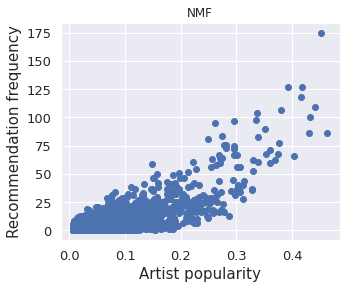

In [ ]:
sns.set(rc = {'figure.figsize':(5,4)})
for i in range(0, len(algo_names)):
    plt.figure()
    #if algo_names[i] != 'Random' and algo_names[i] != 'MostPopular':
     #   plt.gca().set_ylim(0, 300)
    x = df_item_dist_surprise["count"]
    y = df_item_dist_surprise[algo_names[i]]

    plt.plot(x, y, 'o')
    plt.title(algo_names[i])
    plt.xlabel('Artist popularity', fontsize='15')
    plt.ylabel('Recommendation frequency', fontsize='15')
    plt.xticks(fontsize='13')
    plt.yticks(fontsize='13')

In [ ]:
low_gap_vals = []
medium_gap_vals = []
high_gap_vals = []

for i in range(0, len(algo_names)):
    low_gap_vals.append((low_rec_gap_list_surprise[i] - low_GAP) / low_GAP * 100)
    medium_gap_vals.append((medium_rec_gap_list_surprise[i] - med_GAP) / med_GAP * 100)
    high_gap_vals.append((high_rec_gap_list_surprise[i] - high_GAP) / high_GAP * 100)

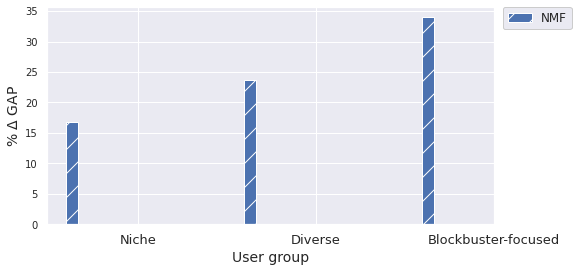

In [ ]:
sns.set(rc = {'figure.figsize':(8,4)})

# set width of bar
barWidth = 0.07

# set height of bar

bars = {}
for i in range(len(algo_names)):
    bars["bars{0}".format(i+1)] = [low_gap_vals[i], medium_gap_vals[i], high_gap_vals[i]]

# Set position of bar on X axis

r = {}
r["r1"] = np.arange(len(bars["bars1"]))

for i in range(len(algo_names)-1):
    r["r{0}".format(i+2)] = [x + barWidth for x in r["r{0}".format(i+1)]]

patterns = [ "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*", "--", "*o",".!."]

# Make the plot
for i in range(len(algo_names)):
  plt.bar(r["r{0}".format(i+1)], bars["bars{0}".format(i+1)], width=barWidth, label=algo_names[i], hatch=patterns[i])

# Add xticks on the middle of the group bars + show legend
plt.xlabel('User group', fontsize='14')
plt.ylabel('% $\Delta$ GAP', fontsize='14')
plt.xticks([r + barWidth + 0.3 for r in range(len(bars["bars1"]))], ['Niche', 'Diverse', 'Blockbuster-focused'], fontsize='13')
plt.yticks(fontsize='10')
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0., framealpha=1, fontsize='12')
plt.show()